This is for the testing of custom dataset balloon test on deectron2

In [17]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
#from detectron2.data import MetadataCatalog

#plot in the cell
%matplotlib inline
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [7]:
for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

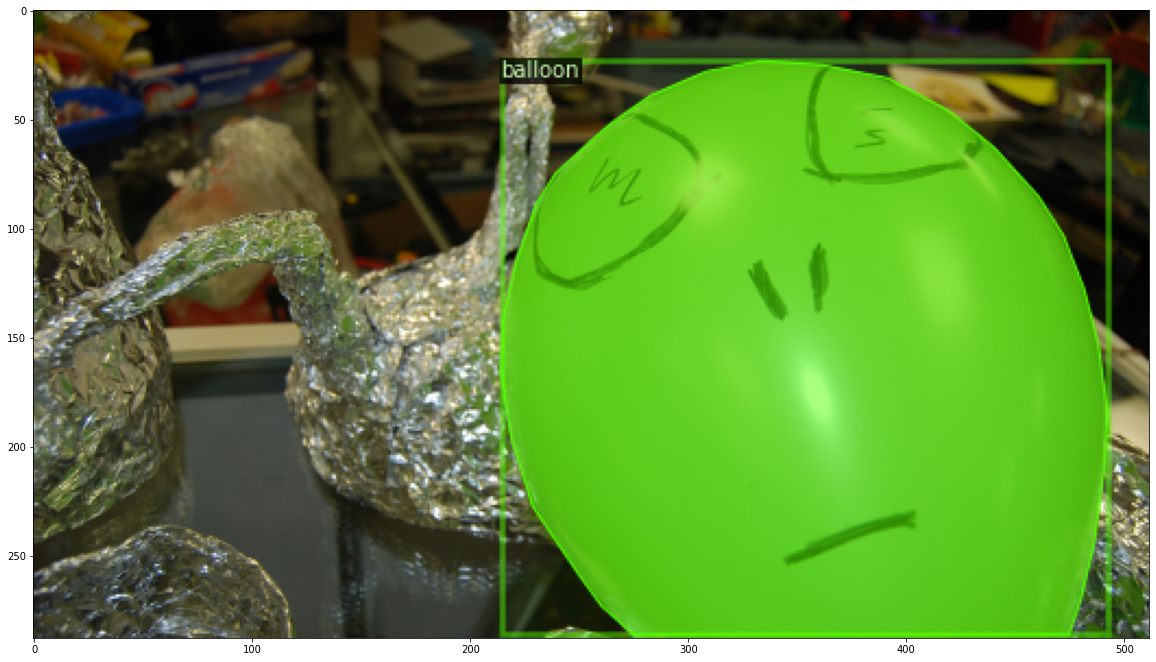

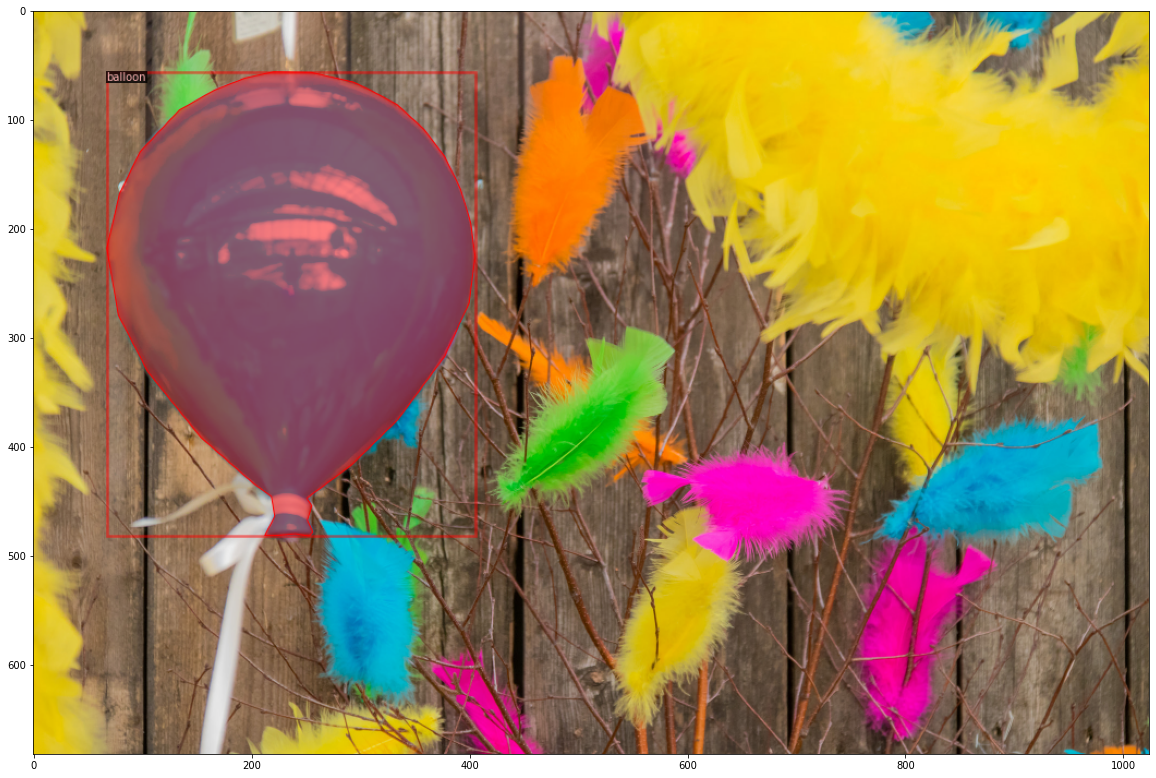

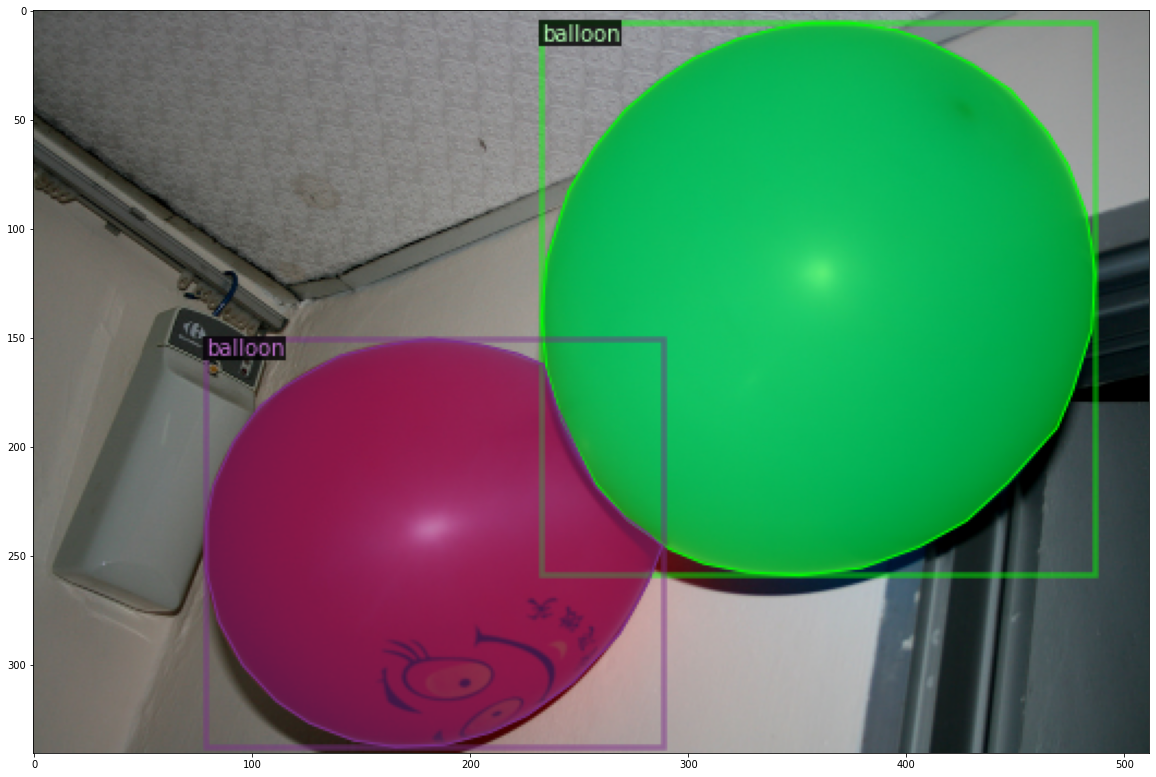

In [9]:
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (20, 16))
    plt.imshow(vis.get_image())

In [10]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
weights_path = "model/model_final_f10217.pkl"
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = weights_path
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[04/14 21:06:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[04/14 21:06:21 d2.data.build]: Removed 0 images with no usable annotations. 61 images left.
[04/14 21:06:21 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 255          |
|            |              |
[04/14 21:06:21 d2.data.common]: Serializing 61 elements to byte tensors and concatenating them all ...
[04/14 21:06:21 d2.data.common]: Serialized dataset takes 0.17 MiB
[04/14 21:06:21 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/14 21:06:21 d2.data.build]: Using training sampler TrainingSampler


'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[04/14 21:06:21 d2.engine.train_loop]: Starting training from iteration 0
[04/14 21:06:27 d2.utils.events]:  eta: 0:01:20  iter: 19  total_loss: 2.018  loss_cls: 0.676  loss_box_reg: 0.622  loss_mask: 0.679  loss_rpn_cls: 0.035  loss_rpn_loc: 0.008  time: 0.2887  data_time: 0.0229  lr: 0.000005  max_mem: 2549M
[04/14 21:06:33 d2.utils.events]:  eta: 0:01:15  iter: 39  total_loss: 2.027  loss_cls: 0.648  loss_box_reg: 0.605  loss_mask: 0.651  loss_rpn_cls: 0.032  loss_rpn_loc: 0.007  time: 0.2867  data_time: 0.0059  lr: 0.000010  max_mem: 2549M
[04/14 21:06:39 d2.utils.events]:  eta: 0:01:09  iter: 59  total_loss: 1.911  loss_cls: 0.566  loss_box_reg: 0.654  loss_mask: 0.596  loss_rpn_cls: 0.025  loss_rpn_loc: 0.008  time: 0.2874  data_time: 0.0089  lr: 0.000015  max_mem: 2549M
[04/14 21:06:45 d2.utils.events]:  eta: 0:01:05  iter: 79  total_loss: 1.777  loss_cls: 0.506  loss_box_reg: 0.643  loss_mask: 0.541  loss_rpn_cls: 0.047  loss_rpn_loc: 0.015  time: 0.2912  data_time: 0.0068  lr:

In [11]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("balloon_val", )
predictor = DefaultPredictor(cfg)

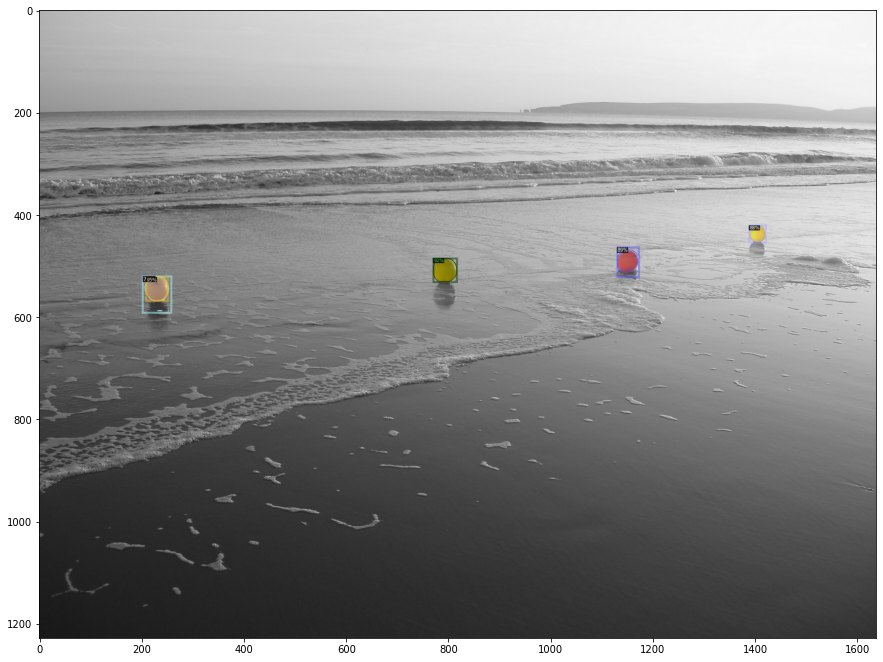

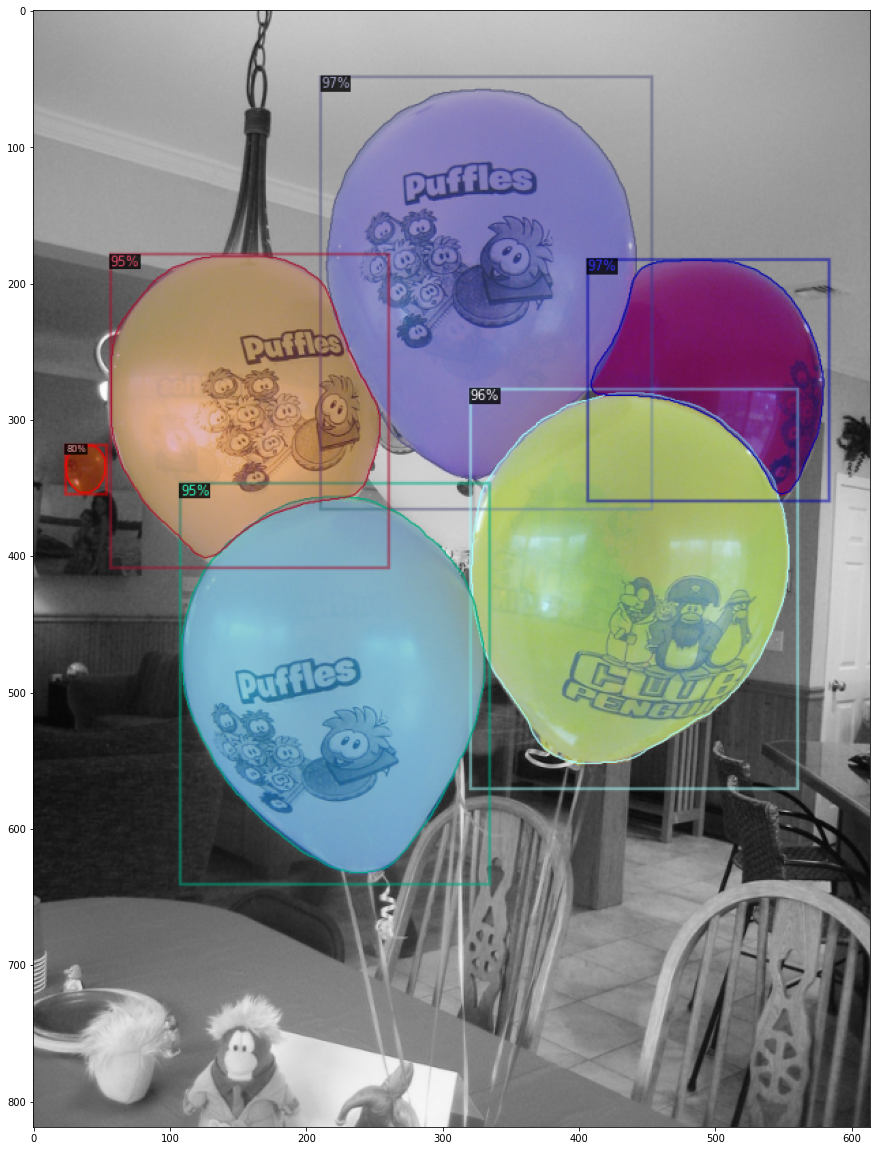

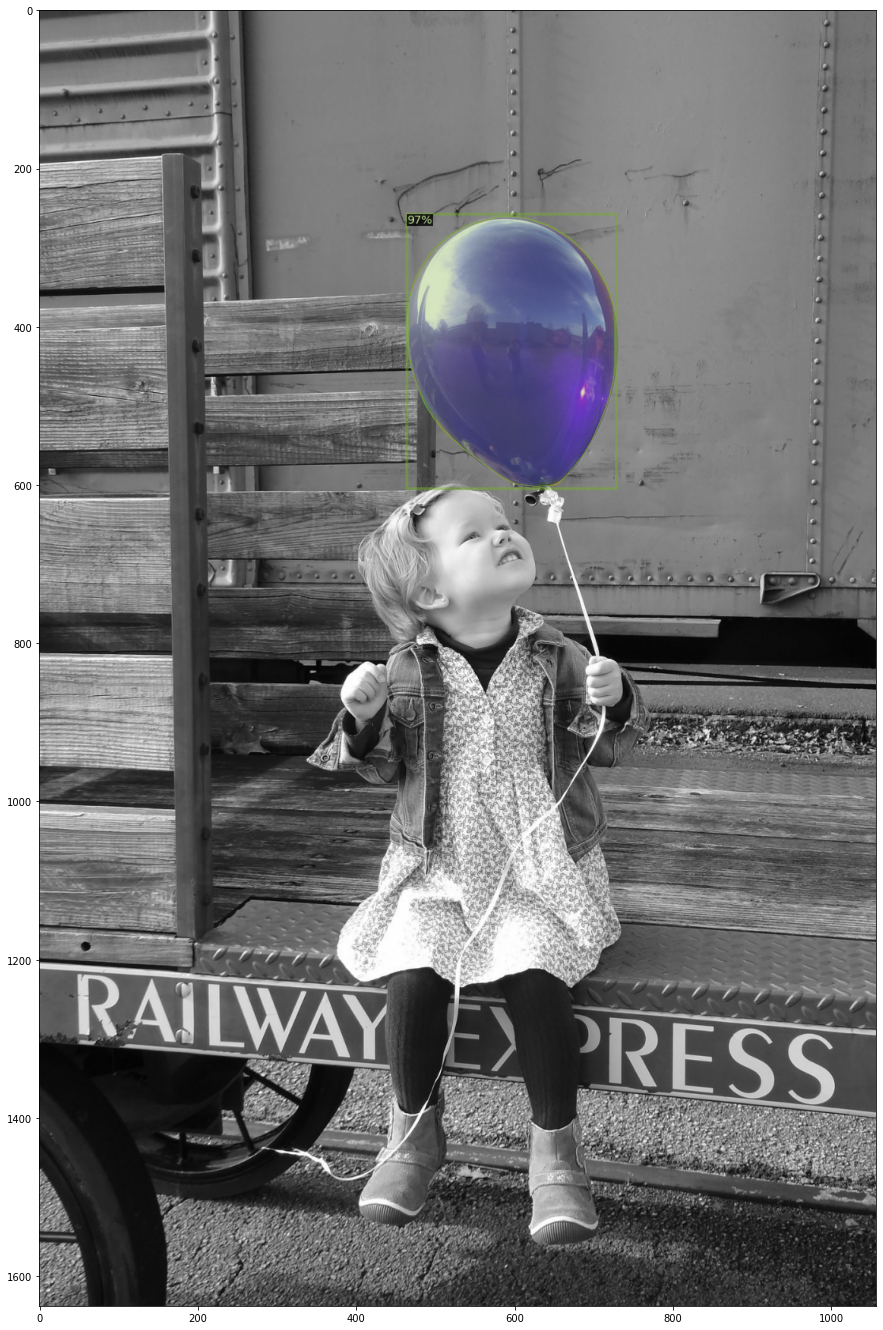

In [16]:
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (15, 112))
    plt.imshow(v.get_image())

In [18]:
evaluator = COCOEvaluator("balloon_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [04/14 21:36:22 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'balloon_val'. Trying to convert it to COCO format ...
[04/14 21:36:22 d2.data.datasets.coco]: Converting annotations of dataset 'balloon_val' to COCO format ...)
[04/14 21:36:23 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[04/14 21:36:23 d2.data.datasets.coco]: Conversion finished, num images: 13, num annotations: 50
[04/14 21:36:23 d2.data.datasets.coco]: Caching COCO format annotations at './output/balloon_val_coco_format.json' ...
[04/14 21:36:23 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 50           |
|            |              |
[04/14 21:36:23 d2.data.common]: Serializing 13 elements to byte tensors and concatenating them all ...
[04/14 21:36:23 d2.data.common]: Serialized dataset takes 0.04 MiB
[04/14 21:36:23 d2.evaluation.evaluator]: Start inference on 13

OrderedDict([('bbox',
              {'AP': 70.84261431027124,
               'AP50': 86.00360200564334,
               'AP75': 81.1758559314578,
               'APs': 24.46251768033946,
               'APm': 53.32802470109343,
               'APl': 86.0391126875258}),
             ('segm',
              {'AP': 78.83236550045285,
               'AP50': 85.48962711920862,
               'AP75': 84.78799579845531,
               'APs': 13.996605374823199,
               'APm': 58.670765008831715,
               'APl': 95.97519526810584})])